In [470]:
import matplotlib.pyplot as plt
from os.path import isfile
import pandas as pd
from sanitizer import sanitize_and_save

In [569]:
plt.style.use("ggplot")
c_lst = plt.rcParams["axes.prop_cycle"].by_key()["color"]
c_lst.append(c_lst.pop(0))
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", c_lst)
if not isfile("../data/refined.parquet"):
    print("Local refined copy missing.")
    print("Proceed to load and process raw backup...")
    sanitize_and_save()
    print("Refined restoration complete.")
df = pd.read_parquet("../data/refined.parquet")

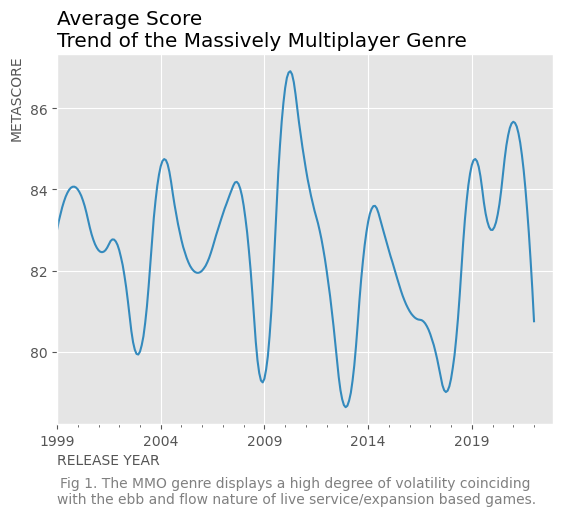

In [686]:
# See df.generes.columns to choose which genres are to be displayed.
focus = ["Massively Multiplayer"]
for genre in focus:
    g = df.general.groupby(df.genres[genre], group_keys=True).get_group(True)
    # Adjust to_period offset string if you wish to analyze different
    # timeframes, make sure resample is always a smaller or equivalent
    # frequency if so.
    g = g.metascore.groupby(df.general.release_date.dt.to_period("Y")).mean()
    g = g.resample("M").asfreq()
    g.index = g.index.to_timestamp()
    g = g.interpolate("polynomial", order=2)  # order=1 to disable smoothing.
    g.plot.line()
#plt.legend(focus)  # Enable if multiple are to be graphed on same plot.
plt.xlabel("RELEASE YEAR", loc="left", fontsize=10)
plt.ylabel("METASCORE", loc="top", fontsize=10)
plt.title(f"Average Score \nTrend of the {focus[0]} Genre", loc="left")
cap="""
    Fig 1. The MMO genre displays a high degree of volatility coinciding 
    with the ebb and flow nature of live service/expansion based games.
    """
plt.figtext(0.5, -.05, cap, wrap=True, ha="center", fontsize=10, color="grey")
plt.savefig("../analysis_results/fig1.png", bbox_inches="tight")
plt.show()

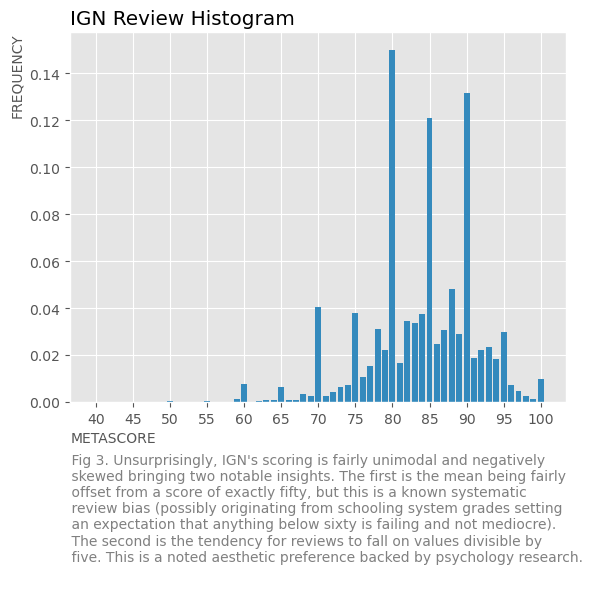

In [717]:
ign = df.critics["IGN"]
counts = ign[ign>=0].value_counts(normalize=True).sort_index()
plt.bar(counts.index, counts)
plt.locator_params(axis='x', nbins=20)
plt.xlabel("METASCORE", loc="left", fontsize=10)
plt.ylabel("FREQUENCY", loc="top", fontsize=10)
plt.title("IGN Review Histogram", loc="left")
cap="""
    Fig 3. Unsurprisingly, IGN's scoring is fairly unimodal and negatively
    skewed bringing two notable insights. The first is the mean being fairly 
    offset from a score of exactly fifty, but this is a known systematic 
    review bias (possibly originating from schooling system grades setting 
    an expectation that anything below sixty is failing and not mediocre).
    The second is the tendency for reviews to fall on values divisible by 
    five. This is a noted aesthetic preference backed by psychology research.
    """
plt.figtext(0.1, -.25, cap, wrap=True, ha="left", fontsize=10, color="grey")
plt.savefig("../analysis_results/fig3.png", bbox_inches="tight")
plt.show()

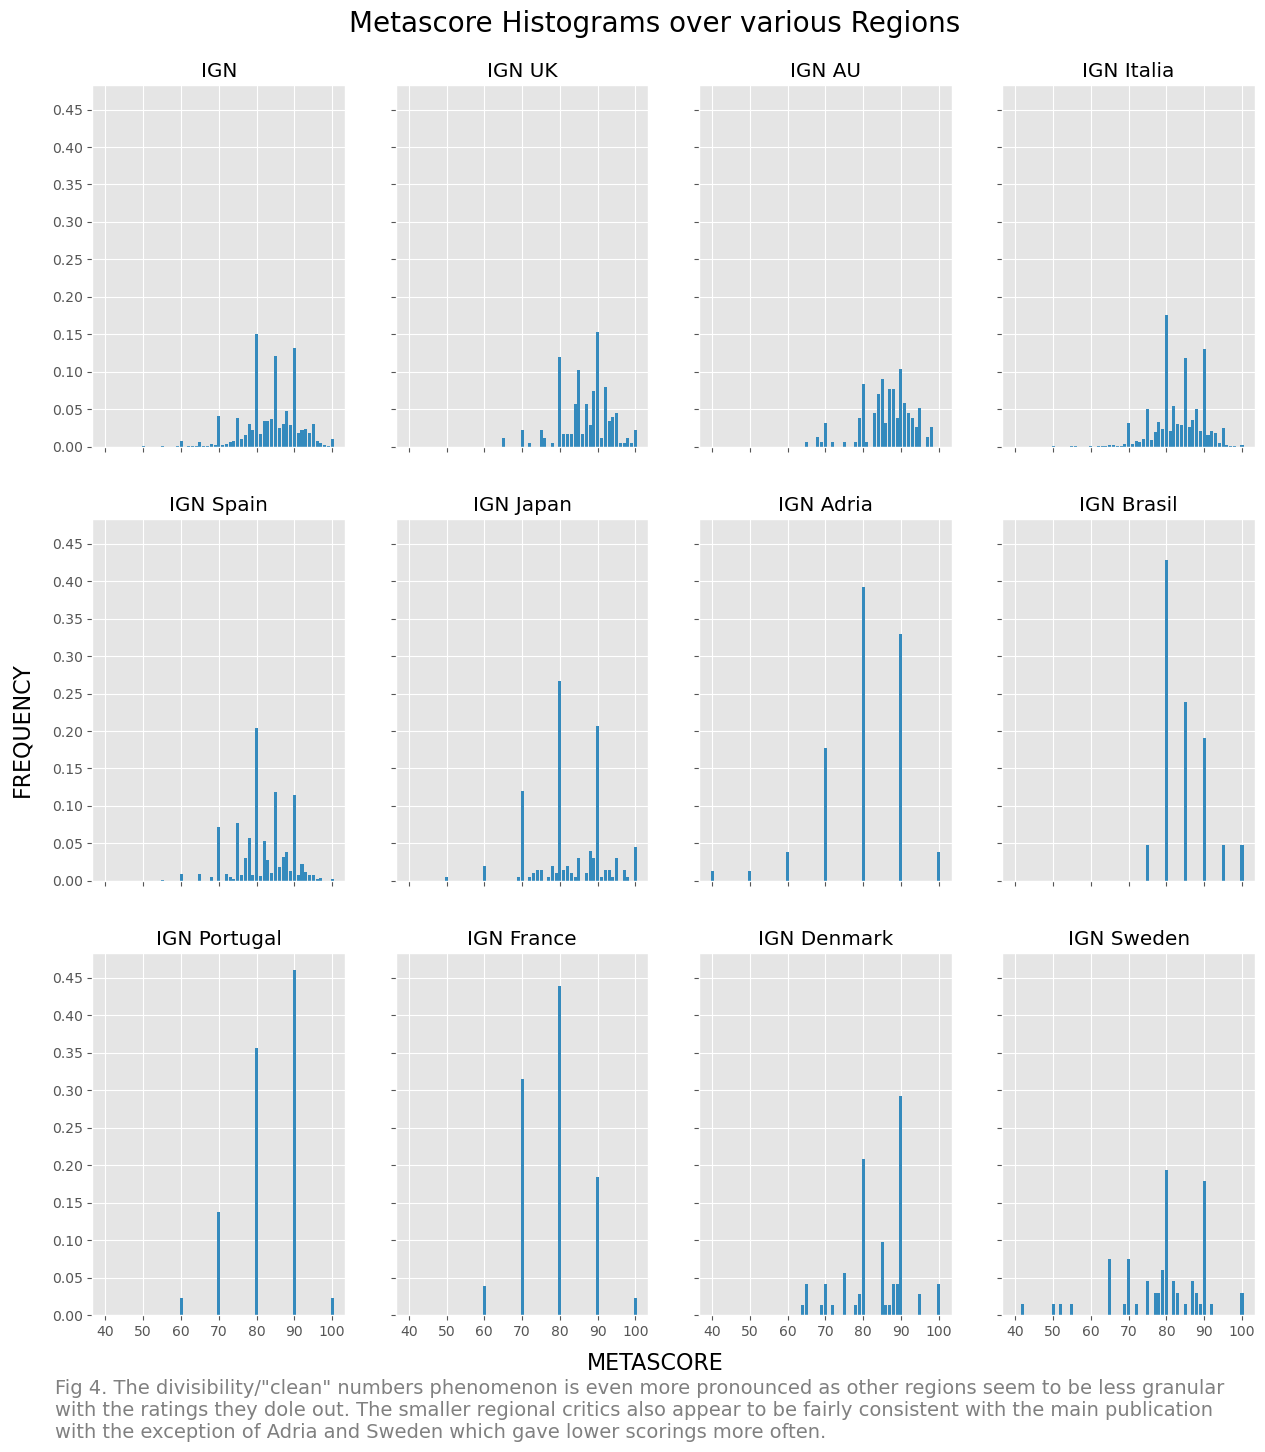

In [755]:
fig, axes = plt.subplots(nrows=3, ncols=4, sharex=True, sharey=True, figsize=(15, 15))
for i, col in enumerate(df.critics.filter(like="IGN").columns):
    regional = df.critics[col]
    counts = regional[regional >= 0].value_counts(normalize=True).sort_index()
    ax = axes[i // 4, i % 4]
    ax.bar(counts.index, counts)
    ax.set_title(col)
plt.locator_params(axis='x', nbins=10)
plt.locator_params(axis='y', nbins=10)
fig.supxlabel("METASCORE", x=.5, y=0.07, fontsize=16)
fig.supylabel("FREQUENCY", x=0.07, y=0.5, fontsize=16)
fig.suptitle("Metascore Histograms over various Regions", fontsize=20)
plt.subplots_adjust(top=0.93)
cap=(
    "Fig 4. The divisibility/\"clean\" numbers phenomenon is even more "
    "pronounced as other regions seem to be less granular \nwith the ratings "
    "they dole out. The smaller regional critics also appear to be fairly "
    "consistent with the main publication \nwith the exception of Adria "
    "and Sweden which gave lower scorings more often. "
    )
plt.figtext(0.1, .03, cap, wrap=True, ha="left", fontsize=14, color="grey")
plt.savefig("../analysis_results/fig4.png", bbox_inches="tight")
plt.show()

In [370]:
df.critics.filter(like="IGN").columns

Index(['IGN', 'IGN UK', 'IGN AU', 'IGN Italia', 'IGN Spain', 'IGN Japan',
       'IGN Adria', 'IGN Brasil', 'IGN Portugal', 'IGN France', 'IGN Denmark',
       'IGN Sweden'],
      dtype='object')

In [603]:
11 // 4

2